In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1) ResNet 기본 블록 구성하기

In [34]:
def build_resnet34_block(
    input_layer,
    num_cnn=3, 
    channel=64,
    block_num=1,
    is_plain=False
):
    # 입력 레이어
    x = input_layer

    # MaxPooling2D
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'{block_num}_pooling'
    )(x)
    
    ## CNN 레이어
    for cnn_num in range(1, num_cnn+1):
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            kernel_initializer='he_normal',
            padding='same',
            name=f'{block_num}_{cnn_num}_1_conv'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'{block_num}_{cnn_num}_1_batch_normal'
        )(x)
        x = keras.layers.Activation(
            "relu", 
            name=f'{block_num}_{cnn_num}_1_activation'
        )(x)
        
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            kernel_initializer='he_normal',
            padding='same',
            name=f'{block_num}_{cnn_num}_2_conv'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'{block_num}_{cnn_num}_2_batch_normal'
        )(x)
        
        if not is_plain:
            if block_num != 1 and cnn_num == 1:
                if identity.shape[-1] != x.shape[-1]:
                    identity = keras.layers.Conv2D(
                        filters=x.shape[-1], 
                        kernel_size=(1, 1), 
                        strides=(1, 1), 
                        padding='same',
                        name=f'{block_num}_{cnn_num}_short'
                    )(identity)

                identity = keras.layers.BatchNormalization(
                    name=f"{block_num}_{cnn_num}_short_bn"
                )(identity)

                x = keras.layers.Add(name=f"{block_num}_{cnn_num}_add")([x,identity])
            
            else: 
                x = keras.layers.Add(name=f"{block_num}_{cnn_num}_add")([x,identity])
                
        x = keras.layers.Activation(
            "relu", 
            name=f'{block_num}_{cnn_num}_2_activation'
        )(x)        
        
    return x

In [69]:
def build_resnet50_block(
    input_layer,
    num_cnn=3, 
    channel=64,
    block_num=1,
    is_plain=False
):
    # 입력 레이어
    x = input_layer

    # MaxPooling2D
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'{block_num}_pooling'
    )(x)

    ## CNN 레이어
    for cnn_num in range(1, num_cnn+1):
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            kernel_initializer='he_normal',
            padding='same',
            name=f'{block_num}_{cnn_num}_1_conv'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'{block_num}_{cnn_num}_1_batch_normal'
        )(x)
        x = keras.layers.Activation(
            "relu", 
            name=f'{block_num}_{cnn_num}_1_activation'
        )(x)
        
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            kernel_initializer='he_normal',
            padding='same',
            name=f'{block_num}_{cnn_num}_2_conv'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'{block_num}_{cnn_num}_2_batch_normal'
        )(x)
        x = keras.layers.Activation(
            "relu", 
            name=f'{block_num}_{cnn_num}_2_activation'
        )(x)
        
        if not is_plain:
            if cnn_num == 1:
                identity = keras.layers.Conv2D(
                    filters=channel*4,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'{block_num}_{cnn_num}_short'
                )(identity)
                identity = keras.layers.BatchNormalization(
                    name=f'{block_num}_{cnn_num}_short_bn'
                )(identity)
        
        x = keras.layers.Conv2D(
            filters=channel*4,
            kernel_size=(1,1),
            kernel_initializer='he_normal',
            padding='same',
            name=f'{block_num}_{cnn_num}_3_conv'
        )(x)
        x = keras.layers.BatchNormalization(
            name=f'{block_num}_{cnn_num}_3_bn'
        )(x)

        if not is_plain:
            x = keras.layers.Add(name=f'{block_num}_{cnn_num}_add')([x,identity])
        
        x = keras.layers.Activation(
            "relu", 
            name=f'{block_num}_{cnn_num}_3_activation'
        )(x)        
        
    return x

In [64]:
# ResNet 모델 자체를 생성하는 함수입니다.
def build_resnet(
    input_shape=(224,224,3),
    num_cnn_list=[3,4,6,3],  # ResNet-34 혹은 ResNet-50 구조에서 사용할 CNN 개수
    channel_list=[64,128,256,512],   # 각 블록의 채널 크기
    num_classes=2,   # 분류할 클래스 수
    is_50=False,      # False면 ResNet-34, True면 ResNet-50
    is_plain=False    # Plain 네트워크 여부 (skip connection을 사용하지 않는지 여부)
):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape, name="model_input")  # input layer를 만들어둡니다.
    output = input_layer
    
    ### Conv1
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size = (7,7),
        strides = 2,
        padding = 'valid', 
        name="0_conv"
    )(output)
    output = keras.layers.BatchNormalization(name="0_batch_normal")(output)
    output = keras.layers.Activation("relu", name="0_activation")(output)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    if not is_50:
        build_resnet_block = build_resnet34_block
    else: 
        build_resnet_block = build_resnet50_block
        
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i+1, 
            is_plain=is_plain
        )
    
    output = keras.layers.AveragePooling2D(padding="same")(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1000')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

### 2) ResNet-34, ResNet-50 Complete Model

In [65]:
resnet34_model = build_resnet(input_shape=(224,224,3), is_50=False, is_plain=False)
plain34_model = build_resnet(input_shape=(224,224,3), is_50=False, is_plain=True)

In [66]:
resnet34_model.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
0_conv (Conv2D)                 (None, 109, 109, 64) 9472        model_input[0][0]                
__________________________________________________________________________________________________
0_batch_normal (BatchNormalizat (None, 109, 109, 64) 256         0_conv[0][0]                     
__________________________________________________________________________________________________
0_activation (Activation)       (None, 109, 109, 64) 0           0_batch_normal[0][0]             
___________________________________________________________________________________________

In [67]:
resnet50_model = build_resnet(input_shape=(224,224,3), is_50=True, is_plain=False)
plain50_model = build_resnet(input_shape=(224,224,3), is_50=True, is_plain=True)

In [68]:
resnet50_model.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
0_conv (Conv2D)                 (None, 109, 109, 64) 9472        model_input[0][0]                
__________________________________________________________________________________________________
0_batch_normal (BatchNormalizat (None, 109, 109, 64) 256         0_conv[0][0]                     
__________________________________________________________________________________________________
0_activation (Activation)       (None, 109, 109, 64) 0           0_batch_normal[0][0]             
___________________________________________________________________________________________

### 3) 일반 네트워크(plain network) 만들기

In [70]:
plain34_model.summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
0_conv (Conv2D)              (None, 109, 109, 64)      9472      
_________________________________________________________________
0_batch_normal (BatchNormali (None, 109, 109, 64)      256       
_________________________________________________________________
0_activation (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
1_pooling (MaxPooling2D)     (None, 54, 54, 64)        0         
_________________________________________________________________
1_1_1_conv (Conv2D)          (None, 54, 54, 64)        36928     
_________________________________________________________________
1_1_1_batch_normal (BatchNor (None, 54, 54, 64)        256

In [71]:
plain50_model.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
0_conv (Conv2D)              (None, 109, 109, 64)      9472      
_________________________________________________________________
0_batch_normal (BatchNormali (None, 109, 109, 64)      256       
_________________________________________________________________
0_activation (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
1_pooling (MaxPooling2D)     (None, 54, 54, 64)        0         
_________________________________________________________________
1_1_1_conv (Conv2D)          (None, 54, 54, 64)        4160      
_________________________________________________________________
1_1_1_batch_normal (BatchNor (None, 54, 54, 64)        256

### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

In [72]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

datasets, info = tfds.load('cats_vs_dogs', 
                     split=['train[:80%]', 'train[80%:]'], 
                     with_info=True, 
                     as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [73]:
train_dataset, test_dataset = datasets

In [74]:
def preprocess_image(image, label):
    image = tf.image.resize(image, [224,224])  # 이미지 크기 조정
    image = image / 255.0  # 정규화
    return image, label

In [75]:
# 전처리 적용
train_dataset = train_dataset.map(preprocess_image).batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(16).prefetch(tf.data.AUTOTUNE)

In [76]:
# 이미지와 라벨 구분
for images, labels in train_dataset.take(1):  # 첫 배치 가져오기
    # 이미지와 라벨 확인
    print("Images shape:", images.shape)  # 이미지 텐서의 shape
    print("Labels shape:", labels.shape)  # 라벨 텐서의 shape

Images shape: (16, 224, 224, 3)
Labels shape: (16,)


In [82]:
## 모델 complie
resnet34_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
plain34_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
resnet50_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
plain50_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)


In [83]:
EPOCH = 20

#### Plain-34 vs ResNet 34

In [84]:
history_resnet34 = resnet34_model.fit(
    train_dataset,
#     steps_per_epoch=int(train_dataset.splits['train'].num_examples/BATCH_SIZE),
#     validation_steps=int(train_dataset.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test_dataset,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
 394/1164 [=========>....................] - ETA: 1:13 - loss: 0.7555 - accuracy: 0.5931

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:07 - loss: 0.7470 - accuracy: 0.5963

 479/1164 [===========>..................] - ETA: 1:05 - loss: 0.7451 - accuracy: 0.5984

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.7316 - accuracy: 0.6029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.7026 - accuracy: 0.6162

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.7008 - accuracy: 0.6178

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.6989 - accuracy: 0.6189

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.6963 - accuracy: 0.6214

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.6959 - accuracy: 0.6214

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.6211

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 181s 106ms/step - loss: 0.6957 - accuracy: 0.6211 - val_loss: 0.7362 - val_accuracy: 0.5901
Epoch 2/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.6193 - accuracy: 0.6588

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:09 - loss: 0.6200 - accuracy: 0.6586

 479/1164 [===========>..................] - ETA: 1:07 - loss: 0.6202 - accuracy: 0.6592

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 52s - loss: 0.6203 - accuracy: 0.6605

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.6101 - accuracy: 0.6701

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.6093 - accuracy: 0.6711

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.6076 - accuracy: 0.6725

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.6065 - accuracy: 0.6735

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.6064 - accuracy: 0.6738

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6065 - accuracy: 0.6737

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 124s 107ms/step - loss: 0.6065 - accuracy: 0.6738 - val_loss: 0.7186 - val_accuracy: 0.6182
Epoch 3/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.5671 - accuracy: 0.7094

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:08 - loss: 0.5670 - accuracy: 0.7087

 479/1164 [===========>..................] - ETA: 1:06 - loss: 0.5657 - accuracy: 0.7096

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 52s - loss: 0.5605 - accuracy: 0.7132

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.5469 - accuracy: 0.7228

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.5460 - accuracy: 0.7229

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.5444 - accuracy: 0.7240

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.5426 - accuracy: 0.7254

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.5426 - accuracy: 0.7254

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.5428 - accuracy: 0.7251

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 122s 105ms/step - loss: 0.5428 - accuracy: 0.7251 - val_loss: 0.8354 - val_accuracy: 0.6172
Epoch 4/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.5040 - accuracy: 0.7513

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:09 - loss: 0.5037 - accuracy: 0.7520

 479/1164 [===========>..................] - ETA: 1:07 - loss: 0.5029 - accuracy: 0.7540

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 53s - loss: 0.4965 - accuracy: 0.7571

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.4868 - accuracy: 0.7626

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.4869 - accuracy: 0.7628

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.4852 - accuracy: 0.7635

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.4845 - accuracy: 0.7640

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.4847 - accuracy: 0.7636

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.4848 - accuracy: 0.7635

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 122s 105ms/step - loss: 0.4848 - accuracy: 0.7635 - val_loss: 0.8630 - val_accuracy: 0.6182
Epoch 5/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.4581 - accuracy: 0.7822

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:08 - loss: 0.4562 - accuracy: 0.7825

 479/1164 [===========>..................] - ETA: 1:06 - loss: 0.4551 - accuracy: 0.7834

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 52s - loss: 0.4458 - accuracy: 0.7906

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.4323 - accuracy: 0.7985

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.4321 - accuracy: 0.7988

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.4305 - accuracy: 0.7997

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.4288 - accuracy: 0.8004

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.4288 - accuracy: 0.8004

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.4288 - accuracy: 0.8003

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 122s 105ms/step - loss: 0.4288 - accuracy: 0.8003 - val_loss: 0.5920 - val_accuracy: 0.7197
Epoch 6/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.3941 - accuracy: 0.8176

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:08 - loss: 0.3924 - accuracy: 0.8196

 479/1164 [===========>..................] - ETA: 1:06 - loss: 0.3930 - accuracy: 0.8186

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 52s - loss: 0.3841 - accuracy: 0.8227

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.3697 - accuracy: 0.8321

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.3698 - accuracy: 0.8322

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.3681 - accuracy: 0.8329

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.3666 - accuracy: 0.8334

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.3664 - accuracy: 0.8335

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.3667 - accuracy: 0.8334

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 122s 105ms/step - loss: 0.3667 - accuracy: 0.8334 - val_loss: 0.6375 - val_accuracy: 0.7184
Epoch 7/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.3368 - accuracy: 0.8542

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:09 - loss: 0.3347 - accuracy: 0.8547

 479/1164 [===========>..................] - ETA: 1:07 - loss: 0.3336 - accuracy: 0.8545

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 52s - loss: 0.3226 - accuracy: 0.8602

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.3054 - accuracy: 0.8705

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.3046 - accuracy: 0.8710

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.3025 - accuracy: 0.8718

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.3010 - accuracy: 0.8725

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.3010 - accuracy: 0.8726

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.8727

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 122s 105ms/step - loss: 0.3009 - accuracy: 0.8728 - val_loss: 0.9351 - val_accuracy: 0.6933
Epoch 8/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.2510 - accuracy: 0.8958

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:09 - loss: 0.2494 - accuracy: 0.8964

 479/1164 [===========>..................] - ETA: 1:07 - loss: 0.2493 - accuracy: 0.8960

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 52s - loss: 0.2421 - accuracy: 0.8998

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.2251 - accuracy: 0.9086

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.2238 - accuracy: 0.9090

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.2219 - accuracy: 0.9100

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.2193 - accuracy: 0.9111

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.2194 - accuracy: 0.9113

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9111

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 122s 105ms/step - loss: 0.2196 - accuracy: 0.9111 - val_loss: 0.7065 - val_accuracy: 0.7747
Epoch 9/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.1738 - accuracy: 0.9337

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:08 - loss: 0.1709 - accuracy: 0.9348

 479/1164 [===========>..................] - ETA: 1:06 - loss: 0.1705 - accuracy: 0.9338

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 52s - loss: 0.1612 - accuracy: 0.9381

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.1455 - accuracy: 0.9450

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.1442 - accuracy: 0.9456

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.1427 - accuracy: 0.9463

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.1415 - accuracy: 0.9466

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.1419 - accuracy: 0.9464

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.1419 - accuracy: 0.9464

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 122s 105ms/step - loss: 0.1419 - accuracy: 0.9464 - val_loss: 0.5696 - val_accuracy: 0.8209
Epoch 10/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.1024 - accuracy: 0.9605

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:09 - loss: 0.0999 - accuracy: 0.9610

 479/1164 [===========>..................] - ETA: 1:06 - loss: 0.0988 - accuracy: 0.9616

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 52s - loss: 0.0942 - accuracy: 0.9638

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.0844 - accuracy: 0.9684

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.0839 - accuracy: 0.9687

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.0832 - accuracy: 0.9689

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.0811 - accuracy: 0.9698

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.0814 - accuracy: 0.9698

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.0820 - accuracy: 0.9697

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 122s 105ms/step - loss: 0.0820 - accuracy: 0.9697 - val_loss: 0.8726 - val_accuracy: 0.7997
Epoch 11/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.0574 - accuracy: 0.9799

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:08 - loss: 0.0570 - accuracy: 0.9799

 479/1164 [===========>..................] - ETA: 1:06 - loss: 0.0581 - accuracy: 0.9790

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 52s - loss: 0.0558 - accuracy: 0.9795

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.0534 - accuracy: 0.9801

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.0534 - accuracy: 0.9800

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.0530 - accuracy: 0.9801

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.0522 - accuracy: 0.9802

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.0523 - accuracy: 0.9802

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9801

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 122s 105ms/step - loss: 0.0526 - accuracy: 0.9801 - val_loss: 0.8497 - val_accuracy: 0.8175
Epoch 12/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.0428 - accuracy: 0.9822

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:09 - loss: 0.0449 - accuracy: 0.9817

 479/1164 [===========>..................] - ETA: 1:07 - loss: 0.0445 - accuracy: 0.9820

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 53s - loss: 0.0413 - accuracy: 0.9841

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.0411 - accuracy: 0.9855

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.0412 - accuracy: 0.9856

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.0413 - accuracy: 0.9856

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.0410 - accuracy: 0.9856

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.0417 - accuracy: 0.9853

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.0415 - accuracy: 0.9854

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 124s 107ms/step - loss: 0.0415 - accuracy: 0.9854 - val_loss: 1.2758 - val_accuracy: 0.7807
Epoch 13/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.0380 - accuracy: 0.9854

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:08 - loss: 0.0399 - accuracy: 0.9855

 479/1164 [===========>..................] - ETA: 1:06 - loss: 0.0396 - accuracy: 0.9854

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 52s - loss: 0.0351 - accuracy: 0.9872

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.0316 - accuracy: 0.9886

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.0317 - accuracy: 0.9886

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.0318 - accuracy: 0.9887

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.0318 - accuracy: 0.9886

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.0323 - accuracy: 0.9885

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.0325 - accuracy: 0.9885

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 122s 105ms/step - loss: 0.0325 - accuracy: 0.9885 - val_loss: 1.0752 - val_accuracy: 0.8055
Epoch 14/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.0217 - accuracy: 0.9932

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:09 - loss: 0.0233 - accuracy: 0.9928

 479/1164 [===========>..................] - ETA: 1:06 - loss: 0.0234 - accuracy: 0.9926

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 52s - loss: 0.0232 - accuracy: 0.9928

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.0232 - accuracy: 0.9924

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.0231 - accuracy: 0.9924

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.0239 - accuracy: 0.9923

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.0239 - accuracy: 0.9923

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.0238 - accuracy: 0.9923

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.0242 - accuracy: 0.9922

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 122s 105ms/step - loss: 0.0242 - accuracy: 0.9922 - val_loss: 1.7340 - val_accuracy: 0.7610
Epoch 15/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.0155 - accuracy: 0.9938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:09 - loss: 0.0160 - accuracy: 0.9940

 479/1164 [===========>..................] - ETA: 1:07 - loss: 0.0167 - accuracy: 0.9935

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 53s - loss: 0.0156 - accuracy: 0.9939

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.0146 - accuracy: 0.9944

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.0146 - accuracy: 0.9944

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.0144 - accuracy: 0.9945

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.0148 - accuracy: 0.9945

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.0147 - accuracy: 0.9946

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9946

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 123s 105ms/step - loss: 0.0146 - accuracy: 0.9946 - val_loss: 1.0068 - val_accuracy: 0.8431
Epoch 16/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.0189 - accuracy: 0.9925

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:08 - loss: 0.0186 - accuracy: 0.9926

 479/1164 [===========>..................] - ETA: 1:06 - loss: 0.0181 - accuracy: 0.9927

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 52s - loss: 0.0161 - accuracy: 0.9932

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.0158 - accuracy: 0.9931

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.0157 - accuracy: 0.9933

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.0154 - accuracy: 0.9934

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.0150 - accuracy: 0.9936

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.0149 - accuracy: 0.9936

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9936

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 122s 105ms/step - loss: 0.0149 - accuracy: 0.9936 - val_loss: 1.1819 - val_accuracy: 0.8212
Epoch 17/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.0085 - accuracy: 0.9965

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:08 - loss: 0.0100 - accuracy: 0.9962

 479/1164 [===========>..................] - ETA: 1:06 - loss: 0.0102 - accuracy: 0.9960

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 52s - loss: 0.0106 - accuracy: 0.9960

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.0097 - accuracy: 0.9964

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.0096 - accuracy: 0.9964

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.0095 - accuracy: 0.9965

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.0096 - accuracy: 0.9965

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.0098 - accuracy: 0.9965

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.0097 - accuracy: 0.9965

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 122s 105ms/step - loss: 0.0097 - accuracy: 0.9965 - val_loss: 1.1107 - val_accuracy: 0.8360
Epoch 18/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.0070 - accuracy: 0.9976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:08 - loss: 0.0062 - accuracy: 0.9980

 479/1164 [===========>..................] - ETA: 1:06 - loss: 0.0060 - accuracy: 0.9980

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 52s - loss: 0.0058 - accuracy: 0.9979

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.0064 - accuracy: 0.9976

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.0063 - accuracy: 0.9977

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.0061 - accuracy: 0.9977

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.0060 - accuracy: 0.9978

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.0059 - accuracy: 0.9978

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9977

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 122s 105ms/step - loss: 0.0059 - accuracy: 0.9977 - val_loss: 1.1594 - val_accuracy: 0.8381
Epoch 19/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.0058 - accuracy: 0.9978

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:08 - loss: 0.0053 - accuracy: 0.9980

 479/1164 [===========>..................] - ETA: 1:06 - loss: 0.0051 - accuracy: 0.9980

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 52s - loss: 0.0051 - accuracy: 0.9981

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.0052 - accuracy: 0.9980

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.0052 - accuracy: 0.9980

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.0054 - accuracy: 0.9980

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.0053 - accuracy: 0.9980

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.0052 - accuracy: 0.9980

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.0057 - accuracy: 0.9980

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 122s 105ms/step - loss: 0.0057 - accuracy: 0.9980 - val_loss: 1.1773 - val_accuracy: 0.8493
Epoch 20/20
 394/1164 [=========>....................] - ETA: 1:15 - loss: 0.0029 - accuracy: 0.9989

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:09 - loss: 0.0028 - accuracy: 0.9989

 479/1164 [===========>..................] - ETA: 1:07 - loss: 0.0028 - accuracy: 0.9988

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 52s - loss: 0.0024 - accuracy: 0.9991

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 12s - loss: 0.0024 - accuracy: 0.9990

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.0024 - accuracy: 0.9990

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.0024 - accuracy: 0.9990

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.0023 - accuracy: 0.9991

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.0023 - accuracy: 0.9991

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9990

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 123s 105ms/step - loss: 0.0024 - accuracy: 0.9990 - val_loss: 1.1395 - val_accuracy: 0.8485


In [85]:
resnet34_model.save("resnet34_model.h5")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


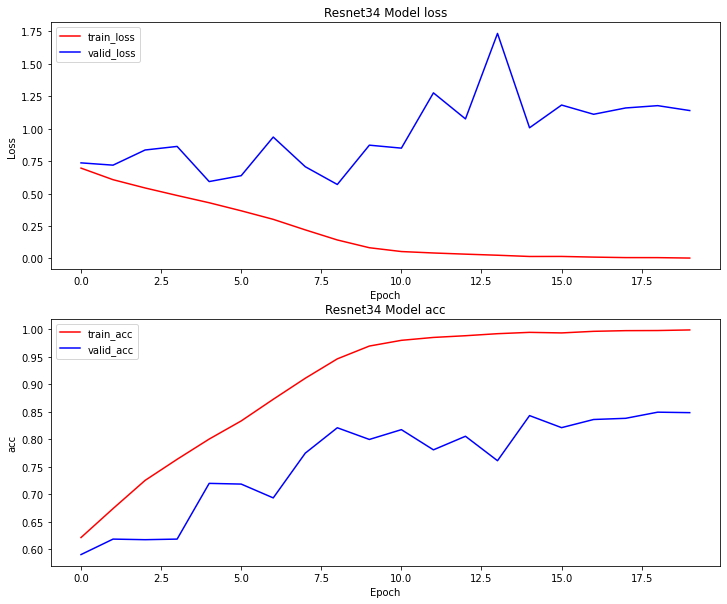

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(history_resnet34.history['loss'], 'r')
plt.plot(history_resnet34.history['val_loss'], 'b')
plt.title('Resnet34 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'valid_loss'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(history_resnet34.history['accuracy'], 'r')
plt.plot(history_resnet34.history['val_accuracy'], 'b')
plt.title('Resnet34 Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['train_acc', 'valid_acc'], loc='upper left')
plt.show()

valid loss가 떨어지는 형태이기보다 상승하는 추세를 보이는 것 같다.  
초기에 바로 과적합이 이루어진 것인가?  
그렇다면 lr을 줄이거나 optimizer를 바꿔서 global minima 를 찾아야하는 것인가?  

valid acc의 경우 확실히 상승하는 형태이긴하다.  

In [87]:
history_plain34 = plain34_model.fit(
    train_dataset,
#     steps_per_epoch=int(train_dataset.splits['train'].num_examples/BATCH_SIZE),
#     validation_steps=int(train_dataset.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test_dataset,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
 394/1164 [=========>....................] - ETA: 1:12 - loss: 0.7248 - accuracy: 0.5154

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:06 - loss: 0.7254 - accuracy: 0.5154

 479/1164 [===========>..................] - ETA: 1:04 - loss: 0.7244 - accuracy: 0.5164

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.7229 - accuracy: 0.5167

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.7167 - accuracy: 0.5213

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.7163 - accuracy: 0.5217

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.7160 - accuracy: 0.5220

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.7150 - accuracy: 0.5237

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.7151 - accuracy: 0.5236

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.7151 - accuracy: 0.5234

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 123s 102ms/step - loss: 0.7150 - accuracy: 0.5235 - val_loss: 0.7620 - val_accuracy: 0.5320
Epoch 2/20
 394/1164 [=========>....................] - ETA: 1:12 - loss: 0.6928 - accuracy: 0.5471

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:06 - loss: 0.6943 - accuracy: 0.5448

 479/1164 [===========>..................] - ETA: 1:04 - loss: 0.6939 - accuracy: 0.5449

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.6928 - accuracy: 0.5487

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.6880 - accuracy: 0.5576

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.6879 - accuracy: 0.5573

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.6871 - accuracy: 0.5585

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.6863 - accuracy: 0.5603

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.6863 - accuracy: 0.5603

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6863 - accuracy: 0.5606

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 120s 103ms/step - loss: 0.6863 - accuracy: 0.5606 - val_loss: 0.6792 - val_accuracy: 0.5778
Epoch 3/20
 394/1164 [=========>....................] - ETA: 1:12 - loss: 0.6683 - accuracy: 0.5903

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:06 - loss: 0.6690 - accuracy: 0.5886

 479/1164 [===========>..................] - ETA: 1:04 - loss: 0.6694 - accuracy: 0.5887

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.6691 - accuracy: 0.5906

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.6653 - accuracy: 0.5982

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.6653 - accuracy: 0.5987

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.6642 - accuracy: 0.6003

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.6637 - accuracy: 0.6007

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.6639 - accuracy: 0.6006

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6641 - accuracy: 0.6004

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 118s 101ms/step - loss: 0.6641 - accuracy: 0.6005 - val_loss: 0.6948 - val_accuracy: 0.5587
Epoch 4/20
 394/1164 [=========>....................] - ETA: 1:12 - loss: 0.6475 - accuracy: 0.6264

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:06 - loss: 0.6490 - accuracy: 0.6264

 479/1164 [===========>..................] - ETA: 1:04 - loss: 0.6488 - accuracy: 0.6268

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.6491 - accuracy: 0.6245

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.6476 - accuracy: 0.6239

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.6480 - accuracy: 0.6231

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.6474 - accuracy: 0.6243

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.6479 - accuracy: 0.6237

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.6478 - accuracy: 0.6236

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6479 - accuracy: 0.6237

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 118s 101ms/step - loss: 0.6479 - accuracy: 0.6237 - val_loss: 0.7056 - val_accuracy: 0.5606
Epoch 5/20
 394/1164 [=========>....................] - ETA: 1:12 - loss: 0.6350 - accuracy: 0.6469

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:06 - loss: 0.6349 - accuracy: 0.6466

 479/1164 [===========>..................] - ETA: 1:04 - loss: 0.6362 - accuracy: 0.6435

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.6344 - accuracy: 0.6439

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.6336 - accuracy: 0.6444

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.6336 - accuracy: 0.6439

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.6331 - accuracy: 0.6447

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.6331 - accuracy: 0.6441

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.6332 - accuracy: 0.6436

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6333 - accuracy: 0.6434

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 118s 101ms/step - loss: 0.6333 - accuracy: 0.6435 - val_loss: 0.6362 - val_accuracy: 0.6365
Epoch 6/20
 394/1164 [=========>....................] - ETA: 1:12 - loss: 0.6195 - accuracy: 0.6609

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:06 - loss: 0.6207 - accuracy: 0.6591

 479/1164 [===========>..................] - ETA: 1:04 - loss: 0.6213 - accuracy: 0.6589

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.6234 - accuracy: 0.6567

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.6210 - accuracy: 0.6560

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.6209 - accuracy: 0.6562

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.6209 - accuracy: 0.6566

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.6211 - accuracy: 0.6553

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.6215 - accuracy: 0.6549

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6216 - accuracy: 0.6548

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 118s 102ms/step - loss: 0.6216 - accuracy: 0.6549 - val_loss: 0.6531 - val_accuracy: 0.6333
Epoch 7/20
 394/1164 [=========>....................] - ETA: 1:13 - loss: 0.6099 - accuracy: 0.6643

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:07 - loss: 0.6113 - accuracy: 0.6631

 479/1164 [===========>..................] - ETA: 1:05 - loss: 0.6111 - accuracy: 0.6639

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.6115 - accuracy: 0.6638

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.6074 - accuracy: 0.6692

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.6070 - accuracy: 0.6700

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.6064 - accuracy: 0.6706

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.6066 - accuracy: 0.6703

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.6065 - accuracy: 0.6703

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6066 - accuracy: 0.6700

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 118s 102ms/step - loss: 0.6066 - accuracy: 0.6701 - val_loss: 0.6512 - val_accuracy: 0.6569
Epoch 8/20
 394/1164 [=========>....................] - ETA: 1:13 - loss: 0.5899 - accuracy: 0.6850

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:07 - loss: 0.5920 - accuracy: 0.6834

 479/1164 [===========>..................] - ETA: 1:05 - loss: 0.5915 - accuracy: 0.6852

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.5934 - accuracy: 0.6827

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.5897 - accuracy: 0.6853

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.5893 - accuracy: 0.6859

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.5885 - accuracy: 0.6872

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.5873 - accuracy: 0.6882

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.5870 - accuracy: 0.6884

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.5866 - accuracy: 0.6887

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 118s 102ms/step - loss: 0.5865 - accuracy: 0.6887 - val_loss: 0.6002 - val_accuracy: 0.6797
Epoch 9/20
 394/1164 [=========>....................] - ETA: 1:13 - loss: 0.5697 - accuracy: 0.7008

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:07 - loss: 0.5701 - accuracy: 0.6999

 479/1164 [===========>..................] - ETA: 1:05 - loss: 0.5702 - accuracy: 0.6999

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.5675 - accuracy: 0.7028

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.5645 - accuracy: 0.7049

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.5642 - accuracy: 0.7054

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.5636 - accuracy: 0.7055

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.5626 - accuracy: 0.7060

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.5627 - accuracy: 0.7063

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.5626 - accuracy: 0.7060

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 118s 102ms/step - loss: 0.5625 - accuracy: 0.7060 - val_loss: 0.5686 - val_accuracy: 0.7190
Epoch 10/20
 394/1164 [=========>....................] - ETA: 1:13 - loss: 0.5509 - accuracy: 0.7157

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:07 - loss: 0.5513 - accuracy: 0.7171

 479/1164 [===========>..................] - ETA: 1:05 - loss: 0.5513 - accuracy: 0.7167

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.5505 - accuracy: 0.7149

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.5469 - accuracy: 0.7166

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.5465 - accuracy: 0.7167

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.5465 - accuracy: 0.7170

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.5463 - accuracy: 0.7173

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.5463 - accuracy: 0.7175

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.5462 - accuracy: 0.7177

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 118s 102ms/step - loss: 0.5461 - accuracy: 0.7177 - val_loss: 0.5630 - val_accuracy: 0.7180
Epoch 11/20
 394/1164 [=========>....................] - ETA: 1:12 - loss: 0.5447 - accuracy: 0.7194

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:06 - loss: 0.5431 - accuracy: 0.7203

 479/1164 [===========>..................] - ETA: 1:04 - loss: 0.5425 - accuracy: 0.7195

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.5388 - accuracy: 0.7223

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.5283 - accuracy: 0.7312

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.5282 - accuracy: 0.7316

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.5273 - accuracy: 0.7322

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.5266 - accuracy: 0.7333

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.5266 - accuracy: 0.7334

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.5262 - accuracy: 0.7336

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 120s 103ms/step - loss: 0.5261 - accuracy: 0.7336 - val_loss: 0.5446 - val_accuracy: 0.7259
Epoch 12/20
 394/1164 [=========>....................] - ETA: 1:12 - loss: 0.5117 - accuracy: 0.7465

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:06 - loss: 0.5088 - accuracy: 0.7484

 479/1164 [===========>..................] - ETA: 1:04 - loss: 0.5079 - accuracy: 0.7495

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.5043 - accuracy: 0.7520

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.4979 - accuracy: 0.7543

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.4985 - accuracy: 0.7538

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.4979 - accuracy: 0.7540

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.4975 - accuracy: 0.7548

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.4975 - accuracy: 0.7549

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.4974 - accuracy: 0.7551

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 118s 101ms/step - loss: 0.4973 - accuracy: 0.7551 - val_loss: 0.5322 - val_accuracy: 0.7489
Epoch 13/20
 394/1164 [=========>....................] - ETA: 1:12 - loss: 0.4842 - accuracy: 0.7625

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:06 - loss: 0.4825 - accuracy: 0.7647

 479/1164 [===========>..................] - ETA: 1:04 - loss: 0.4825 - accuracy: 0.7654

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.4775 - accuracy: 0.7684

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.4693 - accuracy: 0.7738

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.4695 - accuracy: 0.7737

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.4690 - accuracy: 0.7742

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.4676 - accuracy: 0.7755

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.4675 - accuracy: 0.7760

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.4674 - accuracy: 0.7758

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 118s 101ms/step - loss: 0.4674 - accuracy: 0.7759 - val_loss: 0.6806 - val_accuracy: 0.6939
Epoch 14/20
 394/1164 [=========>....................] - ETA: 1:12 - loss: 0.4546 - accuracy: 0.7830

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:06 - loss: 0.4529 - accuracy: 0.7838

 479/1164 [===========>..................] - ETA: 1:04 - loss: 0.4529 - accuracy: 0.7843

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.4488 - accuracy: 0.7866

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.4420 - accuracy: 0.7901

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.4422 - accuracy: 0.7901

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.4415 - accuracy: 0.7907

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.4408 - accuracy: 0.7911

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.4410 - accuracy: 0.7911

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.4406 - accuracy: 0.7914

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 118s 102ms/step - loss: 0.4405 - accuracy: 0.7915 - val_loss: 0.5322 - val_accuracy: 0.7702
Epoch 15/20
 394/1164 [=========>....................] - ETA: 1:12 - loss: 0.4230 - accuracy: 0.7990

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:06 - loss: 0.4201 - accuracy: 0.8009

 479/1164 [===========>..................] - ETA: 1:04 - loss: 0.4195 - accuracy: 0.8006

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.4154 - accuracy: 0.8040

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.4061 - accuracy: 0.8109

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.4063 - accuracy: 0.8113

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.4052 - accuracy: 0.8120

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.4049 - accuracy: 0.8118

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.4051 - accuracy: 0.8118

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.4048 - accuracy: 0.8120

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 118s 101ms/step - loss: 0.4047 - accuracy: 0.8120 - val_loss: 0.4675 - val_accuracy: 0.7880
Epoch 16/20
 394/1164 [=========>....................] - ETA: 1:12 - loss: 0.3793 - accuracy: 0.8263

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:06 - loss: 0.3772 - accuracy: 0.8270

 479/1164 [===========>..................] - ETA: 1:04 - loss: 0.3774 - accuracy: 0.8272

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.3751 - accuracy: 0.8267

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.3660 - accuracy: 0.8328

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.3669 - accuracy: 0.8326

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.3664 - accuracy: 0.8334

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.3663 - accuracy: 0.8338

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.3661 - accuracy: 0.8342

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.3662 - accuracy: 0.8342

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 120s 103ms/step - loss: 0.3661 - accuracy: 0.8342 - val_loss: 0.4811 - val_accuracy: 0.7947
Epoch 17/20
 394/1164 [=========>....................] - ETA: 1:12 - loss: 0.3549 - accuracy: 0.8399

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:06 - loss: 0.3520 - accuracy: 0.8416

 479/1164 [===========>..................] - ETA: 1:04 - loss: 0.3533 - accuracy: 0.8409

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.3483 - accuracy: 0.8447

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.3397 - accuracy: 0.8475

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.3398 - accuracy: 0.8475

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.3384 - accuracy: 0.8480

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.3374 - accuracy: 0.8485

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.3376 - accuracy: 0.8485

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.3375 - accuracy: 0.8486

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 121s 103ms/step - loss: 0.3375 - accuracy: 0.8486 - val_loss: 0.5373 - val_accuracy: 0.7842
Epoch 18/20
 394/1164 [=========>....................] - ETA: 1:12 - loss: 0.3208 - accuracy: 0.8591

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:06 - loss: 0.3160 - accuracy: 0.8624

 479/1164 [===========>..................] - ETA: 1:04 - loss: 0.3157 - accuracy: 0.8629

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.3103 - accuracy: 0.8655

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.3026 - accuracy: 0.8690

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.3026 - accuracy: 0.8687

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.3013 - accuracy: 0.8694

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.3005 - accuracy: 0.8701

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.3006 - accuracy: 0.8702

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.3005 - accuracy: 0.8701

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 118s 102ms/step - loss: 0.3005 - accuracy: 0.8701 - val_loss: 0.4875 - val_accuracy: 0.8108
Epoch 19/20
 394/1164 [=========>....................] - ETA: 1:12 - loss: 0.2762 - accuracy: 0.8780

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:06 - loss: 0.2742 - accuracy: 0.8814

 479/1164 [===========>..................] - ETA: 1:04 - loss: 0.2744 - accuracy: 0.8813

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.2700 - accuracy: 0.8850

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.2616 - accuracy: 0.8876

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.2609 - accuracy: 0.8879

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.2602 - accuracy: 0.8883

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.2591 - accuracy: 0.8888

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.2588 - accuracy: 0.8891

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.2589 - accuracy: 0.8889

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 118s 102ms/step - loss: 0.2588 - accuracy: 0.8889 - val_loss: 0.5588 - val_accuracy: 0.8031
Epoch 20/20
 394/1164 [=========>....................] - ETA: 1:12 - loss: 0.2464 - accuracy: 0.8966

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 458/1164 [==========>...................] - ETA: 1:06 - loss: 0.2470 - accuracy: 0.8960

 479/1164 [===========>..................] - ETA: 1:04 - loss: 0.2489 - accuracy: 0.8952

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 623/1164 [===============>..............] - ETA: 51s - loss: 0.2428 - accuracy: 0.8994

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1039/1164 [=========================>....] - ETA: 11s - loss: 0.2355 - accuracy: 0.9029

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1065/1164 [==========================>...] - ETA: 9s - loss: 0.2351 - accuracy: 0.9030

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1086/1164 [==========================>...] - ETA: 7s - loss: 0.2338 - accuracy: 0.9034

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1140/1164 [============================>.] - ETA: 2s - loss: 0.2325 - accuracy: 0.9039

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1153/1164 [============================>.] - ETA: 1s - loss: 0.2324 - accuracy: 0.9042

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.2324 - accuracy: 0.9042

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 118s 102ms/step - loss: 0.2324 - accuracy: 0.9042 - val_loss: 0.5007 - val_accuracy: 0.8184


In [89]:
plain34_model.save("plain34_model.h5")

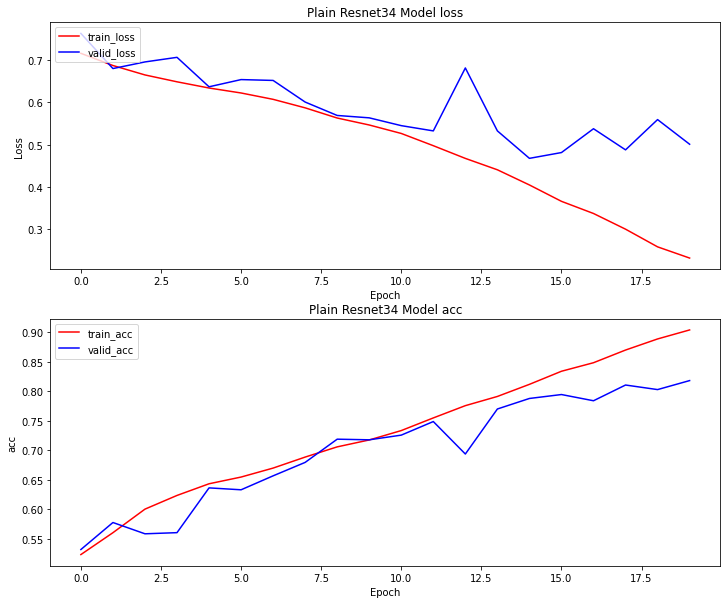

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(history_plain34.history['loss'], 'r')
plt.plot(history_plain34.history['val_loss'], 'b')
plt.title('Plain Resnet34 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'valid_loss'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(history_plain34.history['accuracy'], 'r')
plt.plot(history_plain34.history['val_accuracy'], 'b')
plt.title('Plain Resnet34 Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['train_acc', 'valid_acc'], loc='upper left')
plt.show()

plain의 경우 아직 수렴하지 못한 것 같다.  

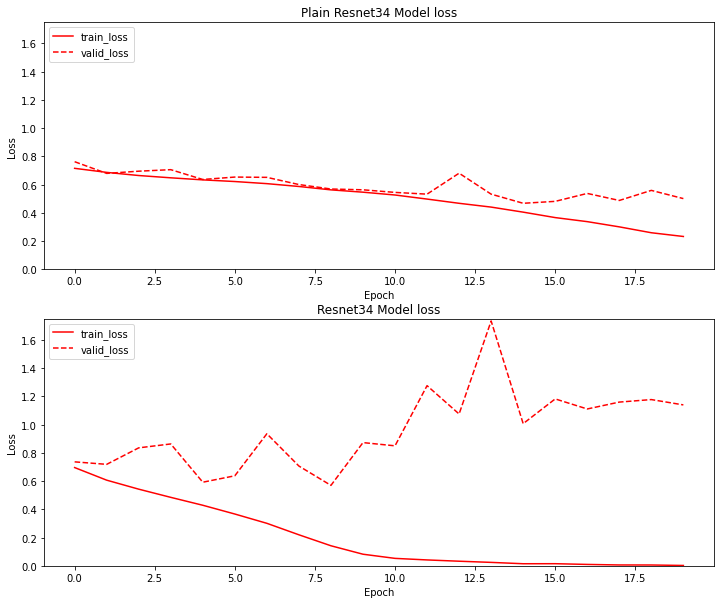

In [93]:
#### Plain-34 vs ResNet 34
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(history_plain34.history['loss'], 'r')
plt.plot(history_plain34.history['val_loss'], 'r', linestyle="--")
plt.title('Plain Resnet34 Model loss')
plt.ylim(0, 1.75)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'valid_loss'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(history_resnet34.history['loss'], 'r')
plt.plot(history_resnet34.history['val_loss'], 'r', linestyle="--")
plt.title('Resnet34 Model loss')
plt.ylim(0, 1.75)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'valid_loss'], loc='upper left')
plt.show()

plain에 비해 resnet이 더 빠르게 수렴하는 것처럼 보인다. 

#### Plain-50 vs ResNet 50

In [94]:
history_resnet50 = resnet50_model.fit(
    train_dataset,
#     steps_per_epoch=int(train_dataset.splits['train'].num_examples/BATCH_SIZE),
#     validation_steps=int(train_dataset.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test_dataset,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.8031 - accuracy: 0.5448

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.7958 - accuracy: 0.5418

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.7947 - accuracy: 0.5433

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.7787 - accuracy: 0.5451

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.7463 - accuracy: 0.5617

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.7454 - accuracy: 0.5618

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.7429 - accuracy: 0.5637

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.7392 - accuracy: 0.5660

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.7384 - accuracy: 0.5666

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.7379 - accuracy: 0.5666

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 218s 179ms/step - loss: 0.7379 - accuracy: 0.5666 - val_loss: 0.7379 - val_accuracy: 0.5681
Epoch 2/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.6637 - accuracy: 0.6178

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:57 - loss: 0.6643 - accuracy: 0.6175

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.6650 - accuracy: 0.6166

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.6610 - accuracy: 0.6211

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.6571 - accuracy: 0.6216

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.6567 - accuracy: 0.6218

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.6551 - accuracy: 0.6230

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.6540 - accuracy: 0.6247

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6541 - accuracy: 0.6249

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.6247

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.6543 - accuracy: 0.6247 - val_loss: 0.6252 - val_accuracy: 0.6567
Epoch 3/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.6364 - accuracy: 0.6430

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.6398 - accuracy: 0.6388

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.6401 - accuracy: 0.6390

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.6385 - accuracy: 0.6419

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.6378 - accuracy: 0.6387

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.6380 - accuracy: 0.6386

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.6365 - accuracy: 0.6397

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.6359 - accuracy: 0.6413

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6356 - accuracy: 0.6417

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.6359 - accuracy: 0.6414

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.6359 - accuracy: 0.6414 - val_loss: 0.6307 - val_accuracy: 0.6468
Epoch 4/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.6191 - accuracy: 0.6619

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:57 - loss: 0.6223 - accuracy: 0.6585

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.6227 - accuracy: 0.6568

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.6216 - accuracy: 0.6569

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.6200 - accuracy: 0.6599

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.6197 - accuracy: 0.6606

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.6184 - accuracy: 0.6617

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.6182 - accuracy: 0.6619

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6179 - accuracy: 0.6623

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.6182 - accuracy: 0.6615

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 213s 183ms/step - loss: 0.6182 - accuracy: 0.6615 - val_loss: 0.6240 - val_accuracy: 0.6584
Epoch 5/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.6055 - accuracy: 0.6691

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.6082 - accuracy: 0.6660

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.6078 - accuracy: 0.6667

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.6088 - accuracy: 0.6671

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.6053 - accuracy: 0.6714

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.6053 - accuracy: 0.6713

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.6041 - accuracy: 0.6722

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.6051 - accuracy: 0.6711

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6049 - accuracy: 0.6712

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.6053 - accuracy: 0.6706

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.6053 - accuracy: 0.6706 - val_loss: 0.6206 - val_accuracy: 0.6526
Epoch 6/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.5960 - accuracy: 0.6800

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.5971 - accuracy: 0.6798

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.5976 - accuracy: 0.6782

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.5983 - accuracy: 0.6762

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.5927 - accuracy: 0.6821

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.5929 - accuracy: 0.6819

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.5915 - accuracy: 0.6827

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.5914 - accuracy: 0.6827

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.5915 - accuracy: 0.6823

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.6819

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.5919 - accuracy: 0.6819 - val_loss: 0.6052 - val_accuracy: 0.6743
Epoch 7/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.5846 - accuracy: 0.6892

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.5869 - accuracy: 0.6882

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.5876 - accuracy: 0.6879

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.5854 - accuracy: 0.6872

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.5778 - accuracy: 0.6929

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.5774 - accuracy: 0.6937

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.5759 - accuracy: 0.6948

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.5761 - accuracy: 0.6949

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.5758 - accuracy: 0.6950

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.5761 - accuracy: 0.6946

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.5761 - accuracy: 0.6946 - val_loss: 0.6405 - val_accuracy: 0.6324
Epoch 8/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.5646 - accuracy: 0.7109

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.5680 - accuracy: 0.7086

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.5689 - accuracy: 0.7066

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.5663 - accuracy: 0.7078

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.5581 - accuracy: 0.7113

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.5581 - accuracy: 0.7112

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.5569 - accuracy: 0.7122

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.5565 - accuracy: 0.7127

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.5564 - accuracy: 0.7126

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.5563 - accuracy: 0.7127

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.5563 - accuracy: 0.7127 - val_loss: 0.5654 - val_accuracy: 0.7113
Epoch 9/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.5398 - accuracy: 0.7298

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.5426 - accuracy: 0.7259

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.5426 - accuracy: 0.7255

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.5409 - accuracy: 0.7261

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.5351 - accuracy: 0.7297

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.5344 - accuracy: 0.7296

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.5333 - accuracy: 0.7305

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.5335 - accuracy: 0.7301

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.5337 - accuracy: 0.7297

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.5338 - accuracy: 0.7293

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.5338 - accuracy: 0.7293 - val_loss: 0.5321 - val_accuracy: 0.7285
Epoch 10/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.5305 - accuracy: 0.7373

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.5314 - accuracy: 0.7370

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.5306 - accuracy: 0.7372

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.5291 - accuracy: 0.7373

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.5203 - accuracy: 0.7405

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.5200 - accuracy: 0.7404

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.5185 - accuracy: 0.7414

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.5184 - accuracy: 0.7415

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.5183 - accuracy: 0.7415

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.5182 - accuracy: 0.7415

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.5182 - accuracy: 0.7415 - val_loss: 0.5540 - val_accuracy: 0.7221
Epoch 11/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.5091 - accuracy: 0.7483

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.5097 - accuracy: 0.7486

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.5091 - accuracy: 0.7491

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.5076 - accuracy: 0.7504

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.4957 - accuracy: 0.7583

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.4951 - accuracy: 0.7586

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.4938 - accuracy: 0.7594

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.4939 - accuracy: 0.7589

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.4937 - accuracy: 0.7588

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.4936 - accuracy: 0.7588

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.4936 - accuracy: 0.7588 - val_loss: 0.7056 - val_accuracy: 0.6763
Epoch 12/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.4822 - accuracy: 0.7654

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:57 - loss: 0.4823 - accuracy: 0.7649

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.4807 - accuracy: 0.7660

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.4791 - accuracy: 0.7667

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.4707 - accuracy: 0.7717

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.4702 - accuracy: 0.7721

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.4684 - accuracy: 0.7730

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.4682 - accuracy: 0.7732

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.4680 - accuracy: 0.7734

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.4682 - accuracy: 0.7736

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.4682 - accuracy: 0.7736 - val_loss: 0.8202 - val_accuracy: 0.6387
Epoch 13/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.4723 - accuracy: 0.7731

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.4705 - accuracy: 0.7768

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.4691 - accuracy: 0.7769

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.4652 - accuracy: 0.7770

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.4535 - accuracy: 0.7842

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.4536 - accuracy: 0.7837

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.4521 - accuracy: 0.7843

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.4522 - accuracy: 0.7841

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.4519 - accuracy: 0.7843

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.7840

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.4521 - accuracy: 0.7840 - val_loss: 0.5545 - val_accuracy: 0.7334
Epoch 14/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.4449 - accuracy: 0.7837

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.4433 - accuracy: 0.7857

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.4429 - accuracy: 0.7857

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.4381 - accuracy: 0.7897

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.4257 - accuracy: 0.8000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.4261 - accuracy: 0.7995

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.4242 - accuracy: 0.8007

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.4243 - accuracy: 0.8007

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.4238 - accuracy: 0.8011

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.4241 - accuracy: 0.8013

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.4241 - accuracy: 0.8013 - val_loss: 0.5503 - val_accuracy: 0.7496
Epoch 15/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.4155 - accuracy: 0.8055

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.4159 - accuracy: 0.8055

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.4144 - accuracy: 0.8064

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.4123 - accuracy: 0.8073

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.3983 - accuracy: 0.8169

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.3990 - accuracy: 0.8168

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.3974 - accuracy: 0.8177

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.3976 - accuracy: 0.8175

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.3972 - accuracy: 0.8180

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.3973 - accuracy: 0.8181

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.3973 - accuracy: 0.8181 - val_loss: 0.5040 - val_accuracy: 0.7638
Epoch 16/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.3851 - accuracy: 0.8286

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.3866 - accuracy: 0.8275

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.3863 - accuracy: 0.8270

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.3806 - accuracy: 0.8291

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.3687 - accuracy: 0.8363

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.3692 - accuracy: 0.8360

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.3673 - accuracy: 0.8367

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.3680 - accuracy: 0.8363

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.3672 - accuracy: 0.8368

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.3673 - accuracy: 0.8369

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.3673 - accuracy: 0.8369 - val_loss: 0.4674 - val_accuracy: 0.7930
Epoch 17/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.3593 - accuracy: 0.8403

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.3582 - accuracy: 0.8414

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.3578 - accuracy: 0.8411

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.3513 - accuracy: 0.8430

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.3365 - accuracy: 0.8516

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.3376 - accuracy: 0.8509

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.3354 - accuracy: 0.8520

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.3360 - accuracy: 0.8513

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.3360 - accuracy: 0.8513

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.3362 - accuracy: 0.8513

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.3362 - accuracy: 0.8513 - val_loss: 0.4945 - val_accuracy: 0.7790
Epoch 18/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.3183 - accuracy: 0.8616

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.3193 - accuracy: 0.8617

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.3188 - accuracy: 0.8618

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.3151 - accuracy: 0.8644

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.3015 - accuracy: 0.8710

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.3025 - accuracy: 0.8708

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.3004 - accuracy: 0.8719

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.3000 - accuracy: 0.8720

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.2995 - accuracy: 0.8721

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.2998 - accuracy: 0.8720

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.2998 - accuracy: 0.8720 - val_loss: 0.6907 - val_accuracy: 0.7612
Epoch 19/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.2702 - accuracy: 0.8849

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.2742 - accuracy: 0.8829

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.2746 - accuracy: 0.8827

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.2721 - accuracy: 0.8831

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.2610 - accuracy: 0.8898

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.2624 - accuracy: 0.8895

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.2603 - accuracy: 0.8906

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.2594 - accuracy: 0.8909

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.2589 - accuracy: 0.8911

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.2592 - accuracy: 0.8911

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 212s 183ms/step - loss: 0.2592 - accuracy: 0.8911 - val_loss: 0.7300 - val_accuracy: 0.7500
Epoch 20/20
 393/1164 [=========>....................] - ETA: 2:07 - loss: 0.2311 - accuracy: 0.9059

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:56 - loss: 0.2323 - accuracy: 0.9063

 478/1164 [===========>..................] - ETA: 1:53 - loss: 0.2344 - accuracy: 0.9056

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:29 - loss: 0.2294 - accuracy: 0.9069

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 20s - loss: 0.2186 - accuracy: 0.9122

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 16s - loss: 0.2194 - accuracy: 0.9121

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 13s - loss: 0.2175 - accuracy: 0.9129

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 4s - loss: 0.2159 - accuracy: 0.9130

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.2158 - accuracy: 0.9130

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.9130

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 206s 177ms/step - loss: 0.2166 - accuracy: 0.9130 - val_loss: 0.9144 - val_accuracy: 0.7401


In [95]:
resnet50_model.save("resnet50_model.h5")

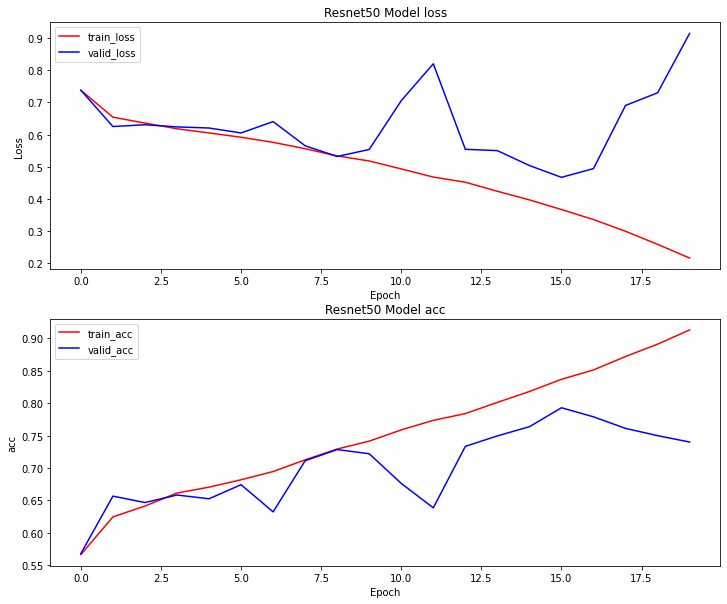

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(history_resnet50.history['loss'], 'r')
plt.plot(history_resnet50.history['val_loss'], 'b')
plt.title('Resnet50 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'valid_loss'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(history_resnet50.history['accuracy'], 'r')
plt.plot(history_resnet50.history['val_accuracy'], 'b')
plt.title('Resnet50 Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['train_acc', 'valid_acc'], loc='upper left')
plt.show()

resnet50의 경우 valid loss에서 확실히 과적합이 이루어지는 구간을 확인할 수 있다. 
그러나 train loss를 볼 경우 아직 수렴되지 못한 듯 하다.  

In [97]:
history_plain50 = plain50_model.fit(
    train_dataset,
#     steps_per_epoch=int(train_dataset.splits['train'].num_examples/BATCH_SIZE),
#     validation_steps=int(train_dataset.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=test_dataset,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.7352 - accuracy: 0.5312

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.7370 - accuracy: 0.5268

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.7358 - accuracy: 0.5275

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.7308 - accuracy: 0.5302

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.7241 - accuracy: 0.5336

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.7238 - accuracy: 0.5328

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.7236 - accuracy: 0.5331

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.7228 - accuracy: 0.5337

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.7226 - accuracy: 0.5339

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.7225 - accuracy: 0.5334

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 184s 152ms/step - loss: 0.7225 - accuracy: 0.5334 - val_loss: 0.7060 - val_accuracy: 0.5193
Epoch 2/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.6991 - accuracy: 0.5247

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.6997 - accuracy: 0.5228

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.6996 - accuracy: 0.5230

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6990 - accuracy: 0.5242

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6971 - accuracy: 0.5276

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6972 - accuracy: 0.5268

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6973 - accuracy: 0.5266

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6971 - accuracy: 0.5268

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6970 - accuracy: 0.5270

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6971 - accuracy: 0.5268

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 176s 152ms/step - loss: 0.6971 - accuracy: 0.5268 - val_loss: 0.6975 - val_accuracy: 0.5258
Epoch 3/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.6940 - accuracy: 0.5196

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.6947 - accuracy: 0.5141

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.6946 - accuracy: 0.5144

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6939 - accuracy: 0.5162

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6937 - accuracy: 0.5200

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6936 - accuracy: 0.5205

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6936 - accuracy: 0.5206

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6937 - accuracy: 0.5212

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6937 - accuracy: 0.5208

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5202

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 176s 152ms/step - loss: 0.6937 - accuracy: 0.5203 - val_loss: 1.5585 - val_accuracy: 0.5353
Epoch 4/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.6944 - accuracy: 0.5097

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.6946 - accuracy: 0.5042

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.6949 - accuracy: 0.5027

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6943 - accuracy: 0.5068

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6938 - accuracy: 0.5117

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6937 - accuracy: 0.5122

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6936 - accuracy: 0.5120

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6937 - accuracy: 0.5114

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6937 - accuracy: 0.5113

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5113

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 176s 152ms/step - loss: 0.6937 - accuracy: 0.5113 - val_loss: 0.7341 - val_accuracy: 0.5226
Epoch 5/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.6932 - accuracy: 0.5194

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.6933 - accuracy: 0.5181

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.6936 - accuracy: 0.5179

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6936 - accuracy: 0.5168

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6929 - accuracy: 0.5192

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6928 - accuracy: 0.5191

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6927 - accuracy: 0.5199

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6928 - accuracy: 0.5202

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6928 - accuracy: 0.5203

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5203

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 177s 152ms/step - loss: 0.6927 - accuracy: 0.5203 - val_loss: 0.7636 - val_accuracy: 0.5385
Epoch 6/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.6918 - accuracy: 0.5262

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.6920 - accuracy: 0.5248

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.6921 - accuracy: 0.5233

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6922 - accuracy: 0.5226

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6914 - accuracy: 0.5248

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6915 - accuracy: 0.5240

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6915 - accuracy: 0.5241

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6916 - accuracy: 0.5227

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6916 - accuracy: 0.5221

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6916 - accuracy: 0.5222

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 177s 152ms/step - loss: 0.6916 - accuracy: 0.5222 - val_loss: 0.6922 - val_accuracy: 0.5284
Epoch 7/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.6903 - accuracy: 0.5274

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.6909 - accuracy: 0.5286

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.6909 - accuracy: 0.5284

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6910 - accuracy: 0.5249

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6905 - accuracy: 0.5264

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6906 - accuracy: 0.5258

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6906 - accuracy: 0.5256

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6907 - accuracy: 0.5255

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6907 - accuracy: 0.5253

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6906 - accuracy: 0.5256

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 177s 152ms/step - loss: 0.6906 - accuracy: 0.5256 - val_loss: 0.6927 - val_accuracy: 0.5249
Epoch 8/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.6915 - accuracy: 0.5231

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.6918 - accuracy: 0.5220

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.6918 - accuracy: 0.5216

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6916 - accuracy: 0.5252

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6915 - accuracy: 0.5225

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6915 - accuracy: 0.5222

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6915 - accuracy: 0.5219

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6915 - accuracy: 0.5215

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6915 - accuracy: 0.5218

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6914 - accuracy: 0.5222

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 177s 152ms/step - loss: 0.6914 - accuracy: 0.5222 - val_loss: 0.6976 - val_accuracy: 0.5200
Epoch 9/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.6896 - accuracy: 0.5296

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.6896 - accuracy: 0.5293

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.6898 - accuracy: 0.5299

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6895 - accuracy: 0.5321

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6892 - accuracy: 0.5328

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6891 - accuracy: 0.5331

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6890 - accuracy: 0.5335

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6892 - accuracy: 0.5340

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6892 - accuracy: 0.5337

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5341

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 177s 152ms/step - loss: 0.6891 - accuracy: 0.5341 - val_loss: 0.6912 - val_accuracy: 0.5262
Epoch 10/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.6885 - accuracy: 0.5383

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.6893 - accuracy: 0.5335

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.6894 - accuracy: 0.5337

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6898 - accuracy: 0.5348

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6901 - accuracy: 0.5332

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6901 - accuracy: 0.5334

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6900 - accuracy: 0.5337

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6901 - accuracy: 0.5334

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6902 - accuracy: 0.5330

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6901 - accuracy: 0.5331

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 185s 159ms/step - loss: 0.6901 - accuracy: 0.5332 - val_loss: 0.6911 - val_accuracy: 0.5258
Epoch 11/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.6900 - accuracy: 0.5316

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.6897 - accuracy: 0.5331

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.6901 - accuracy: 0.5315

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6890 - accuracy: 0.5381

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6858 - accuracy: 0.5486

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6853 - accuracy: 0.5505

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6849 - accuracy: 0.5512

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6846 - accuracy: 0.5529

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6847 - accuracy: 0.5527

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6848 - accuracy: 0.5523

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 177s 152ms/step - loss: 0.6848 - accuracy: 0.5523 - val_loss: 0.6908 - val_accuracy: 0.5307
Epoch 12/20
 393/1164 [=========>....................] - ETA: 1:48 - loss: 0.6805 - accuracy: 0.5658

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:39 - loss: 0.6808 - accuracy: 0.5644

 478/1164 [===========>..................] - ETA: 1:36 - loss: 0.6812 - accuracy: 0.5637

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6810 - accuracy: 0.5652

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6800 - accuracy: 0.5667

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6796 - accuracy: 0.5674

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6797 - accuracy: 0.5669

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6799 - accuracy: 0.5668

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6798 - accuracy: 0.5672

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.6800 - accuracy: 0.5666

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 176s 152ms/step - loss: 0.6800 - accuracy: 0.5666 - val_loss: 0.6841 - val_accuracy: 0.5473
Epoch 13/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.6739 - accuracy: 0.5781

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.6742 - accuracy: 0.5770

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.6746 - accuracy: 0.5764

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6754 - accuracy: 0.5748

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6742 - accuracy: 0.5786

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6739 - accuracy: 0.5793

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6739 - accuracy: 0.5796

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6734 - accuracy: 0.5812

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6736 - accuracy: 0.5806

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.5804

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 177s 152ms/step - loss: 0.6737 - accuracy: 0.5804 - val_loss: 0.6699 - val_accuracy: 0.5957
Epoch 14/20
 393/1164 [=========>....................] - ETA: 1:48 - loss: 0.6633 - accuracy: 0.6027

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:39 - loss: 0.6647 - accuracy: 0.6007

 478/1164 [===========>..................] - ETA: 1:36 - loss: 0.6653 - accuracy: 0.5998

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6640 - accuracy: 0.5997

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6631 - accuracy: 0.6008

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6628 - accuracy: 0.6010

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6626 - accuracy: 0.6012

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6623 - accuracy: 0.6016

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6626 - accuracy: 0.6011

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6626 - accuracy: 0.6007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 176s 151ms/step - loss: 0.6626 - accuracy: 0.6007 - val_loss: 0.6746 - val_accuracy: 0.5978
Epoch 15/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.6566 - accuracy: 0.6034

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.6577 - accuracy: 0.6033

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.6584 - accuracy: 0.6022

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6591 - accuracy: 0.6022

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6593 - accuracy: 0.6015

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6593 - accuracy: 0.6016

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6587 - accuracy: 0.6031

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6589 - accuracy: 0.6033

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6592 - accuracy: 0.6025

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.6025

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 177s 152ms/step - loss: 0.6593 - accuracy: 0.6025 - val_loss: 0.6827 - val_accuracy: 0.5991
Epoch 16/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.6535 - accuracy: 0.6155

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.6548 - accuracy: 0.6111

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.6560 - accuracy: 0.6111

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6553 - accuracy: 0.6111

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6568 - accuracy: 0.6092

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6571 - accuracy: 0.6090

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6566 - accuracy: 0.6093

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6577 - accuracy: 0.6083

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6577 - accuracy: 0.6083

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6578 - accuracy: 0.6078

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 177s 152ms/step - loss: 0.6578 - accuracy: 0.6078 - val_loss: 0.6661 - val_accuracy: 0.6004
Epoch 17/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.6495 - accuracy: 0.6183

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.6501 - accuracy: 0.6172

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.6514 - accuracy: 0.6157

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6518 - accuracy: 0.6151

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6497 - accuracy: 0.6186

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6496 - accuracy: 0.6184

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6490 - accuracy: 0.6192

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6489 - accuracy: 0.6201

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6492 - accuracy: 0.6200

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6494 - accuracy: 0.6195

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 176s 152ms/step - loss: 0.6494 - accuracy: 0.6195 - val_loss: 0.6824 - val_accuracy: 0.5789
Epoch 18/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.6447 - accuracy: 0.6296

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.6486 - accuracy: 0.6216

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.6498 - accuracy: 0.6200

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6498 - accuracy: 0.6181

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6482 - accuracy: 0.6203

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6481 - accuracy: 0.6199

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6475 - accuracy: 0.6207

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6475 - accuracy: 0.6207

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6474 - accuracy: 0.6213

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6475 - accuracy: 0.6212

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 185s 159ms/step - loss: 0.6475 - accuracy: 0.6211 - val_loss: 0.6453 - val_accuracy: 0.6264
Epoch 19/20
 393/1164 [=========>....................] - ETA: 1:48 - loss: 0.6413 - accuracy: 0.6298

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:39 - loss: 0.6403 - accuracy: 0.6309

 478/1164 [===========>..................] - ETA: 1:36 - loss: 0.6414 - accuracy: 0.6275

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6415 - accuracy: 0.6278

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6362 - accuracy: 0.6342

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6362 - accuracy: 0.6340

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6354 - accuracy: 0.6347

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6351 - accuracy: 0.6365

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6352 - accuracy: 0.6363

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1164 [============================>.] - ETA: 0s - loss: 0.6351 - accuracy: 0.6369

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 176s 152ms/step - loss: 0.6351 - accuracy: 0.6369 - val_loss: 0.6777 - val_accuracy: 0.6113
Epoch 20/20
 393/1164 [=========>....................] - ETA: 1:49 - loss: 0.6295 - accuracy: 0.6455

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 457/1164 [==========>...................] - ETA: 1:40 - loss: 0.6291 - accuracy: 0.6443

 478/1164 [===========>..................] - ETA: 1:37 - loss: 0.6282 - accuracy: 0.6444

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 622/1164 [===============>..............] - ETA: 1:16 - loss: 0.6268 - accuracy: 0.6485

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1038/1164 [=========================>....] - ETA: 17s - loss: 0.6222 - accuracy: 0.6519

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


1064/1164 [==========================>...] - ETA: 14s - loss: 0.6222 - accuracy: 0.6524

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1085/1164 [==========================>...] - ETA: 11s - loss: 0.6215 - accuracy: 0.6535

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


1139/1164 [============================>.] - ETA: 3s - loss: 0.6217 - accuracy: 0.6540

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1152/1164 [============================>.] - ETA: 1s - loss: 0.6215 - accuracy: 0.6541

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1164/1164 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.6539

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1164/1164 [==============================] - 176s 151ms/step - loss: 0.6216 - accuracy: 0.6539 - val_loss: 0.6475 - val_accuracy: 0.6283


In [98]:
plain50_model.save("plain50_model.h5")

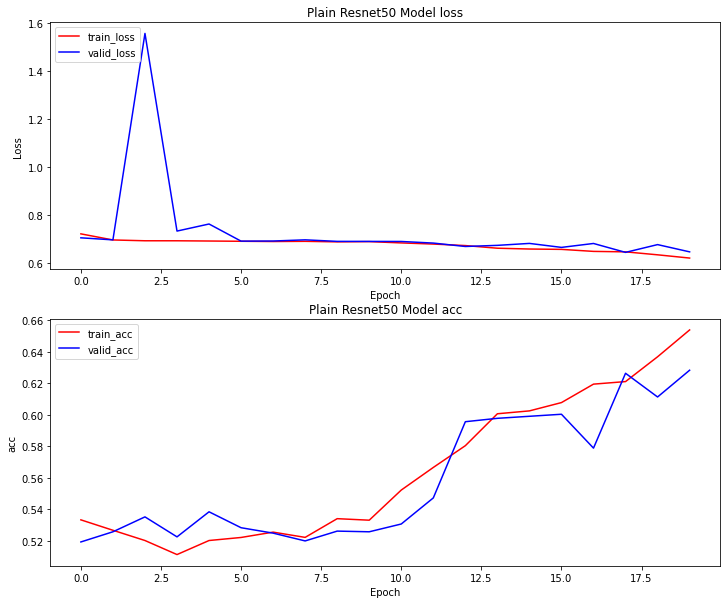

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(history_plain50.history['loss'], 'r')
plt.plot(history_plain50.history['val_loss'], 'b')
plt.title('Plain Resnet50 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'valid_loss'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(history_plain50.history['accuracy'], 'r')
plt.plot(history_plain50.history['val_accuracy'], 'b')
plt.title('Plain Resnet50 Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['train_acc', 'valid_acc'], loc='upper left')
plt.show()

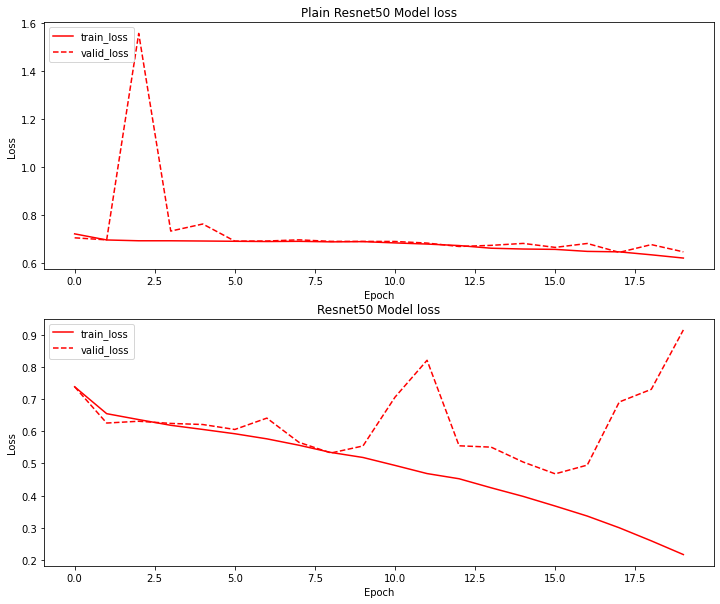

In [101]:
#### Plain-50 vs ResNet 50
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(history_plain50.history['loss'], 'r')
plt.plot(history_plain50.history['val_loss'], 'r', linestyle="--")
plt.title('Plain Resnet50 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'valid_loss'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(history_resnet50.history['loss'], 'r')
plt.plot(history_resnet50.history['val_loss'], 'r', linestyle="--")
plt.title('Resnet50 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'valid_loss'], loc='upper left')
plt.show()

#### Plain vs ResNet

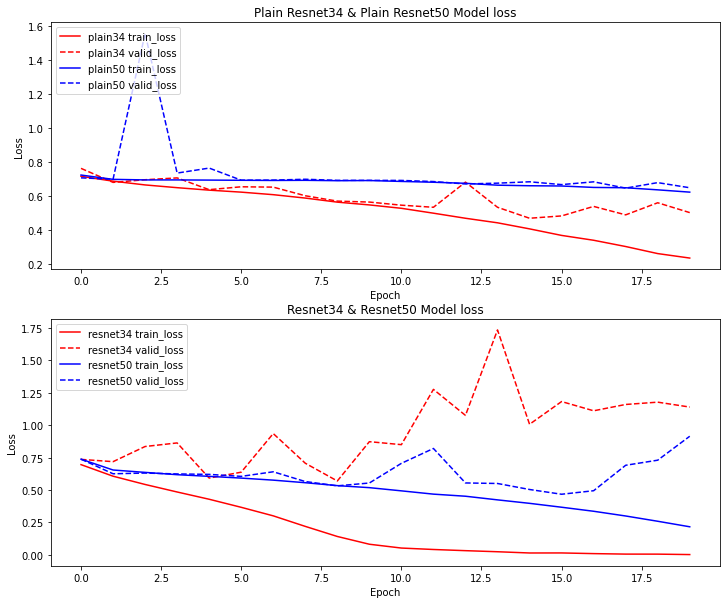

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(history_plain34.history['loss'], 'r')
plt.plot(history_plain34.history['val_loss'], 'r', linestyle="--")

plt.plot(history_plain50.history['loss'], 'b')
plt.plot(history_plain50.history['val_loss'], 'b', linestyle="--")

plt.title('Plain Resnet34 & Plain Resnet50 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain34 train_loss', 'plain34 valid_loss', 'plain50 train_loss', 'plain50 valid_loss'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(history_resnet34.history['loss'], 'r')
plt.plot(history_resnet34.history['val_loss'], 'r', linestyle="--")

plt.plot(history_resnet50.history['loss'], 'b')
plt.plot(history_resnet50.history['val_loss'], 'b', linestyle="--")

plt.title('Resnet34 & Resnet50 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34 train_loss', 'resnet34 valid_loss', 'resnet50 train_loss', 'resnet50 valid_loss'], loc='upper left')
plt.show()